# SEMANTIVE: DATA SCIENTIST RECRUITMENT TASK

##### Please download and load the  [abalone dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/).  

##### You can use information from [this](https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names) file to add the proper headers to the columns. 

The whole task will be driven by supervised learning problem.
Let's define target variable as $Rings / 1.5$ (it rougly corresponds to abalone's age).  
We strongly encourage you use scikit-learn for the modeling tasks (but feel free to use different tools if you think they are appropriate).  

##### First 2 tasks are obligatory. From the tasks 3-5 you can pick and complete 2.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/'

names = ['sex', 'length', 'diameter', 'height', 'whole weight', 'shucked weight', 
         'viscera weight', 'schell weight', 'target']
df =  pd.read_csv(url + 'abalone.data', names=names)

df['target'] /= 1.5

***
# 1. Data exploration

##### Explore the data  and provide a short summary of your findings. Pay attention to the target variable.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
sex               4177 non-null object
length            4177 non-null float64
diameter          4177 non-null float64
height            4177 non-null float64
whole weight      4177 non-null float64
shucked weight    4177 non-null float64
viscera weight    4177 non-null float64
schell weight     4177 non-null float64
target            4177 non-null float64
dtypes: float64(8), object(1)
memory usage: 293.8+ KB


Findings:
 * 4177 observations
 * 8 explanatory variable
 * 1 target variable
 * none of the variables contain NaNs
 * 7 out of 8 explanatory variables are continuous (float) and 1 is categorical (object)
 * after transformation (Rings/1.5) target value is continuous but primarily 
 from data set discription we know that it was an integer value in range 1-29, 
 we will consider it later how to approach the problem - classification or regression
 

In [3]:
df.describe()

length     diameter       height  whole weight  shucked weight  \
count  4177.000000  4177.000000  4177.000000   4177.000000     4177.000000   
mean      0.523992     0.407881     0.139516      0.828742        0.359367   
std       0.120093     0.099240     0.041827      0.490389        0.221963   
min       0.075000     0.055000     0.000000      0.002000        0.001000   
25%       0.450000     0.350000     0.115000      0.441500        0.186000   
50%       0.545000     0.425000     0.140000      0.799500        0.336000   
75%       0.615000     0.480000     0.165000      1.153000        0.502000   
max       0.815000     0.650000     1.130000      2.825500        1.488000   

       viscera weight  schell weight       target  
count     4177.000000    4177.000000  4177.000000  
mean         0.180594       0.238831     6.622456  
std          0.109614       0.139203     2.149446  
min          0.000500       0.001500     0.666667  
25%          0.093500       0.130000     5.333333  
50%          0.171000       0.234000     6.000000  
75%          0.253000       0.329000     7.333333  
max          0.760000       1.005000    19.333333

Findings:
* all explanatory variables are routhly in the same range, we may try data normalization but it can be not nessesary
* minimum value for height is 0 which is suspicious and in general not possible
* for variables: 'height', 'whole weight', 'shucked weight', 'viscera weight' and 'schell weight' maximum value is far beyond the mean (and taking into account std and quantiles) can be considered as containing outliers

In [4]:
df[df['height']==0]

sex  length  diameter  height  whole weight  shucked weight  \
1257   I   0.430      0.34     0.0         0.428          0.2065   
3996   I   0.315      0.23     0.0         0.134          0.0575   

      viscera weight  schell weight    target  
1257          0.0860         0.1150  5.333333  
3996          0.0285         0.3505  4.000000

There are only two values like that, so that might be not worth an effort, nevertheless  we
dig dipper

In [5]:
df['height'].sort_values().head(10)

3996    0.000
1257    0.000
236     0.010
2169    0.015
1174    0.015
3902    0.020
694     0.020
1987    0.025
2381    0.025
3190    0.025
Name: height, dtype: float64

In [6]:
pd.set_option("display.max_rows", 30)
df['height'].value_counts().sort_index()

0.000      2
0.010      1
0.015      2
0.020      2
0.025      5
0.030      6
0.035      6
0.040     13
0.045     11
0.050     18
0.055     25
0.060     26
0.065     39
0.070     47
0.075     61
        ... 
0.185    103
0.190    103
0.195     78
0.200     68
0.205     45
0.210     23
0.215     31
0.220     17
0.225     13
0.230     10
0.235      6
0.240      4
0.250      3
0.515      1
1.130      1
Name: height, Length: 51, dtype: int64

Findings:
* height is measured with the precision of 0.005, so values equal 0 are probably not the errors, we will leave it unchanged
* we can notice clear 2 outliers with height 0.515 and 1.130

In [7]:
df[df['height'].isin([0.515, 1.13])]

sex  length  diameter  height  whole weight  shucked weight  \
1417   M   0.705     0.565   0.515         2.210          1.1075   
2051   F   0.455     0.355   1.130         0.594          0.3320   

      viscera weight  schell weight    target  
1417          0.4865         0.5120  6.666667  
2051          0.1160         0.1335  5.333333

Findings:
* observation with height 0.515 - values for other variables like length and weights are also high, so that might be 
not an error, just outlier. Might be reasonable to limit the value to second largest one 0.25 (to limit the influence of the observation on linear models)
* observation with height 1.130 - values for other variables like length and weights are low, first thought is that
value for height was mistaken and should be 0.113 or rounded 0.115

#### Understand target variable

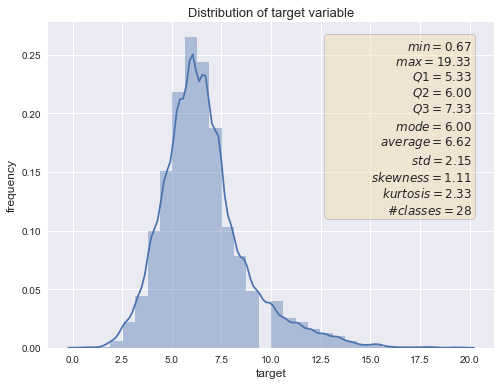

In [9]:
plt.figure(figsize=(8, 6))
ax = plt.axes()
sns.distplot(df['target'], kde=True, ax=ax, bins=30) 
plt.title('Distribution of target variable', fontsize=13)
plt.ylabel('frequency', fontsize=12)
plt.xlabel('target', fontsize=12)

target = df['target']
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textStr = '${min}=%.2f$\n \
            ${max}=%.2f$\n \
            ${Q1}=%.2f$\n \
            ${Q2}=%.2f$\n \
            ${Q3}=%.2f$\n \
            ${mode}=%.2f$\n \
            ${average}=%.2f$\n \
            ${std}=%.2f$\n \
            ${skewness}=%.2f$\n \
            ${kurtosis}=%.2f$\n \
            ${\# classes}=%i$' % \
          (target.min(), target.max(), target.quantile(0.25), target.quantile(0.5), target.quantile(0.75), target.mode(), 
           target.mean(), target.std(), target.skew(), target.kurtosis(), target.nunique())
ax.text(0.95, 0.95, textStr, transform=ax.transAxes, fontsize=14, size=12,
        verticalalignment='top', horizontalalignment='right', bbox=props)

Findings:
* Values of target variable (age) varies between 0.67 and 19.33. Half of observations are in range 5.33 - 7.33 (high concentration) with the median value equals 6 (which is the same as mode). 
* Distribution shows right skewness of data and concentration of data in tails higher than in normal distribution (kurtosis=2.33 calculated using Fisher's definition). 
* Target variable consist of 28 highly imbalanced classes, furthermore classes have natural order (age is basically a continuous variable). It might be better to approach a problem as a regression.

#### Univariate outliers detection

C:\Program Files\Anaconda\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


length  diameter   height  whole weight  shucked weight  \
0.0005  0.13000   0.09544  0.01044      0.010720        0.004500   
0.0010  0.13588   0.10088  0.01588      0.014088        0.005000   
0.0030  0.16000   0.11264  0.03000      0.019264        0.007264   
0.9500  0.69000   0.54500  0.20000      1.694900        0.740200   
0.9700  0.71000   0.56000  0.20500      1.828580        0.822220   
0.9900  0.73500   0.58000  0.22000      2.144420        0.997780   
0.9500  0.69000   0.54500  0.20000      1.694900        0.740200   
0.9970  0.75736   0.60000  0.23500      2.389024        1.147916   
0.9990  0.77500   0.62412  0.24824      2.549648        1.244444   

        viscera weight  schell weight     target  
0.0005        0.002044       0.003544   2.000000  
0.0010        0.002588       0.004176   2.000000  
0.0030        0.004500       0.005000   2.000000  
0.9500        0.379600       0.480000  10.666667  
0.9700        0.409000       0.520000  12.000000  
0.9900        0.476100       0.620000  13.333333  
0.9500        0.379600       0.480000  10.666667  
0.9970        0.522972       0.717080  15.333333  
0.9990        0.572652       0.843840  16.549333

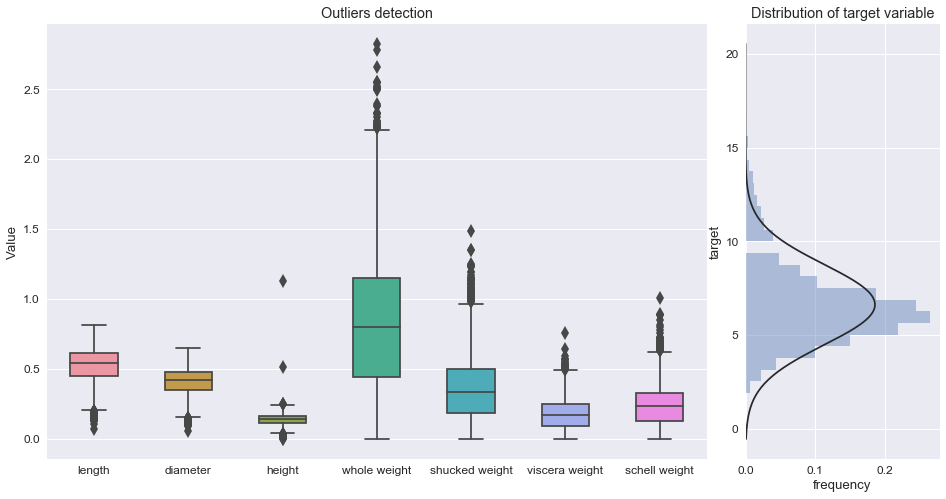

In [11]:
from scipy.stats import norm
import matplotlib.gridspec as gridspec

columns = ['length', 'diameter', 'height', 'whole weight', 'shucked weight',
       'viscera weight', 'schell weight']

sns.set(font_scale=1.2)
plt.figure(figsize=(16, 8))
gspec = gridspec.GridSpec(1, 4)

ax = plt.subplot(gspec[0, :3])
sns.boxplot(df[columns], width=0.5, fliersize=10)
ax.set_title('Outliers detection')
ax.set_ylabel('Value')

ax = plt.subplot(gspec[0, 3:])
sns.distplot(df['target'], ax=ax, kde=False, fit=norm, bins=30, vertical=True) 
ax.set_title('Distribution of target variable')
ax.set_ylabel('target')
ax.set_xlabel('frequency')

df.quantile([0.0005, 0.001, 0.003, 0.95, 0.97, 0.99, 0.95, 0.997, 0.999])

Boxplot is a simple way to determine possible outliers. Displayed points (outliers) are those which values exceeding whiskers which by default are set to 1.5 * IQR (IQR = Q3 - Q1) from the edges of the box. Q1 and Q3 are consecutively first and third quantile.
* Using this method we find lot of outliers, but we need to have in mind that the distribution of our target variable has right skewness. Eliminating some of the shown outliers might be harmfull for prediction accuracy (especially for those rare observations with target value > 10). The right way of dealing with outliers should be determined by cross-validation. 
* The most obvious outliers are those found before (for height).

target>10  target<5   all  mean target  ratio >10  ratio <5
sex                                                             
F          122        64  1307         7.42      0.093     0.049
I           24       648  1342         5.26      0.018     0.483
M          115       127  1528         7.14      0.075     0.083

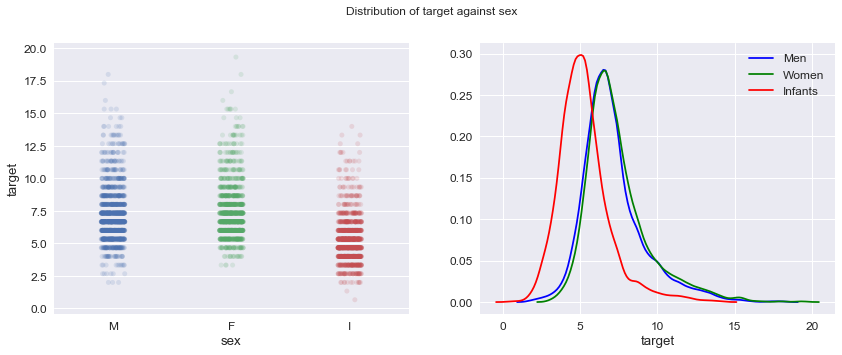

In [14]:
plt.figure(figsize=(14, 5))
plt.suptitle('Distribution of target against sex')

plt.subplot(1, 2, 1)
sns.stripplot(x="sex", y="target", data=df, jitter=0.1, alpha=0.15) 

plt.subplot(1, 2, 2)
M = df.loc[df['sex']=='M', 'target']
F = df.loc[df['sex']=='F', 'target']
I = df.loc[df['sex']=='I', 'target']
sns.distplot(M, kde=True, color='blue', hist=False, label='Men') 
sns.distplot(F, kde=True, color='green', hist=False, label='Women') 
sns.distplot(I, kde=True, color='red', hist=False, label='Infants') 

# Find the percentage of individuals with age > 10  and age < 5 among all individuals 
# for every sex separately
gt10_counts = df.loc[df['target']>10, ['sex', 'target']].groupby('sex').count()
lt10_counts = df.loc[df['target']<5, ['sex', 'target']].groupby('sex').count()
all_count = df.loc[:, ['sex', 'target']].groupby('sex').count()
mean_target = df.loc[:, ['sex', 'target']].groupby('sex').mean()

sex_counts = pd.concat([gt10_counts, lt10_counts, all_count, np.round(mean_target, 2),
                             np.round(gt10_counts/all_count, 3), np.round(lt10_counts/all_count, 3)],
                       axis=1)
sex_counts.columns = ['target>10', 'target<5', 'all', 'mean target', 'ratio >10', 'ratio <5']
sex_counts

We can notice that distribution for men and women is quite similar. There are some very young individuals for men though, whereas for women don't. There is around 8.3% of men below age of 5, while this ratio for women accounts for 4.9%. We can notice that women tend to live longer. We can find confirmation for this theory in distribution plot, average lifespan and percentage of individuals who outlived 10 years (units - depending on interpretation of target variable).
Distribution for infants differs considerably, it is shifted toward lower values. Individuals younger than 5 constitute almost a half of all recorded infants. 

We might consider to create new variable on a side which joins two categories (M and F) into one (adults). Distributions for M and F are not the same though, so leaving original variable 'sex' in dataset is justified.

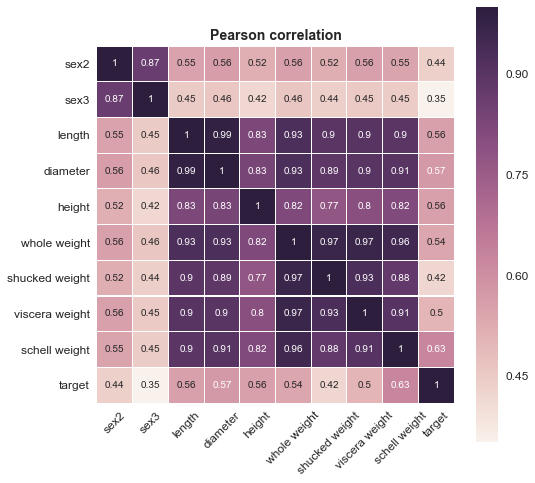

In [15]:
df_copy = df.copy()

plt.figure(figsize=(8, 8))
# We need to transform categorical variable first and ensure right order 
df_copy['sex3'] = df_copy['sex'].astype('category', categories=['I', 'F', 'M']).cat.codes
df_copy['sex2'] = df_copy['sex3'].where(df_copy['sex3'] == 0, 1)

sns.heatmap(df_copy[['sex2', 'sex3'] + df.columns.tolist()].corr(), linewidths=0.1, vmax=1.0,
            square=True, linecolor='white', annot=True)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(rotation=45)
plt.title('Pearson correlation', fontsize=14, fontweight='bold')

sex3 is equal to the original variable 'sex' from the data set (with 3 categories {M, F, I}). For analysis purpose I created additional variable named 'sex2'. In this variable categories M and F are joined together. Variable holds one of the value: 'I' (infant), 'A' (adult). 

Findings:
* All of the explanatory variables have positive correlation with target variable. 
* The most correlated with target is variable 'shell weight', the least - 'sex2' and 'sex3'
* Explanatory variables are highly correlated between each other (that might be a problem for linear models - it needs to be handled correctly)
 

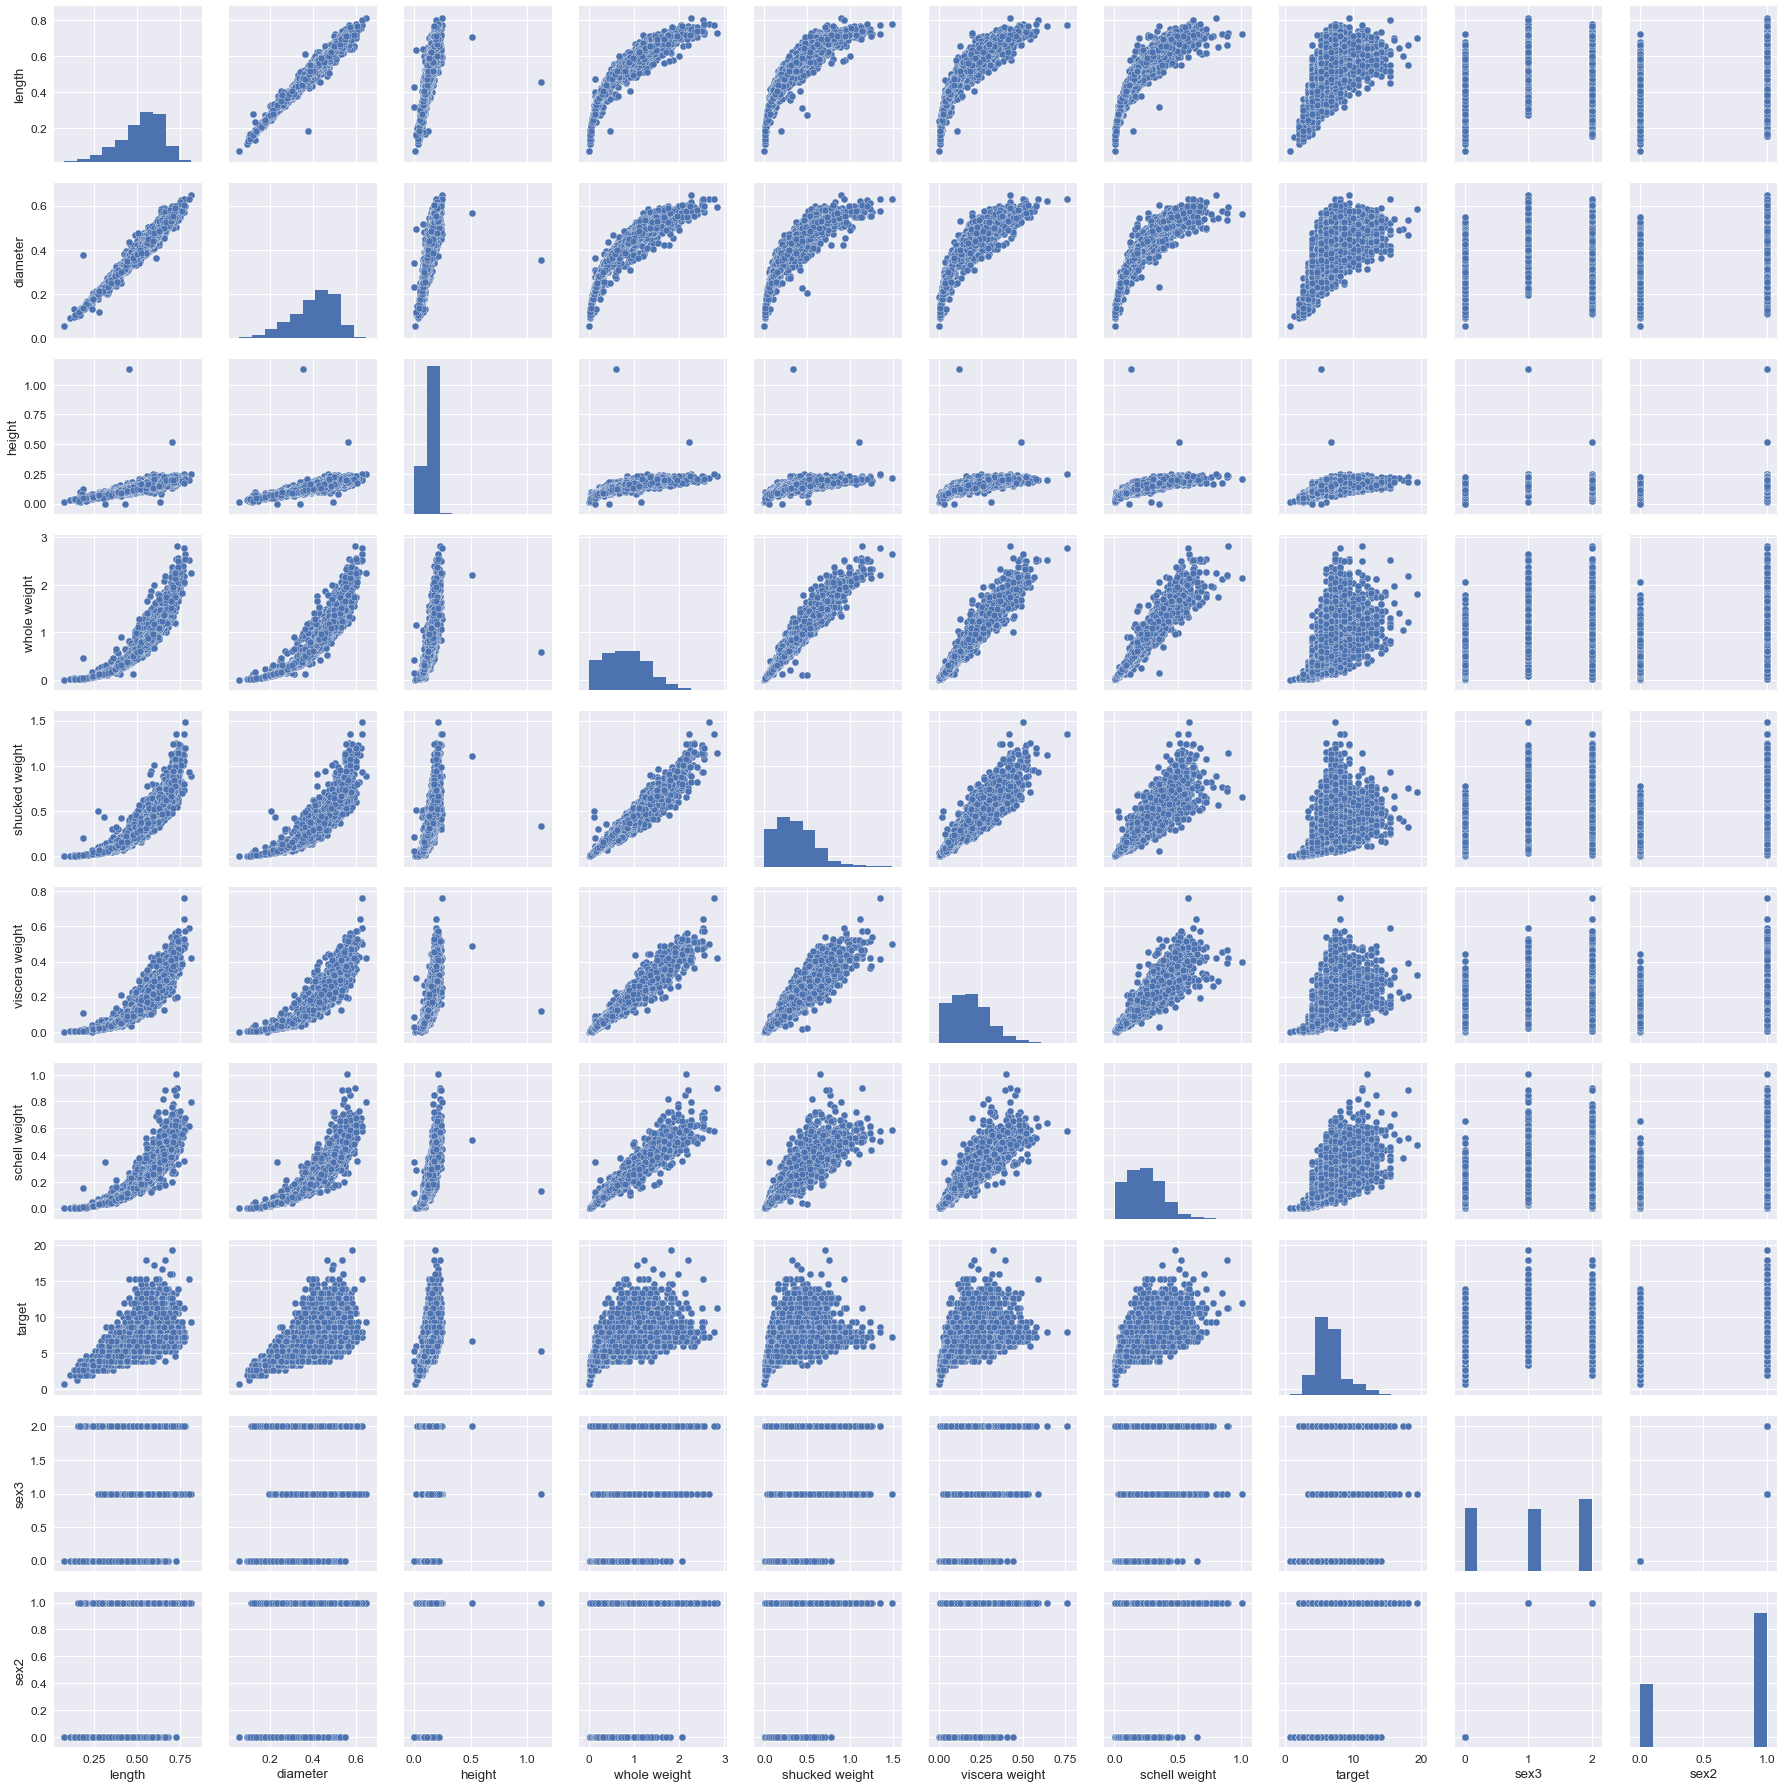

In [16]:
sns.pairplot(df_copy)

We can notice that a lot of explanatory variables are related to each other in exponential way. When we look at distrubition of this variables against target we can observe that really young individuals (with low target value) tend to have all of the variable at very low level. When we move toward higher age this relationship fade. We can also notice e.g. that men tend to be longer than women (and of course infants), what again gives argument for leaving sex feature untouched (do not join M and F into one category - adults). 

***
# 2. Supervised learning

##### Prepare the data for the modeling.  

###### Choose 2 supervised learning algorithms, that you think are suitable for this problem. Describe shortly how these algorithms work. Use them on the data and describe the results.  
  
Note. that we're more interested in comprehensive description and explanation of your choice than in model scores, so we don't expect you to tune your model yet.

First of all we define metric by which we will compare our models. There are several choices for regression problems. I chose RMSE (it could be also R^2 metric, but maybe not MAE as it produce linear score which means that all the individual differences are weighted equally in the average and we want to punish more those where difference is significent). 

Because cross-validation is as matter of 5th task I do not concern about it right now (even though comparing performance of the models would be more reliable if we use CV). For this very moment I use ratio of 80/20 as a split into train and test data sets. I decided two split data using stratification.

In [17]:
from sklearn.metrics import mean_squared_error
import numpy as np

def RMSE(y_true, preds):
    return np.sqrt(mean_squared_error(y_true, preds))

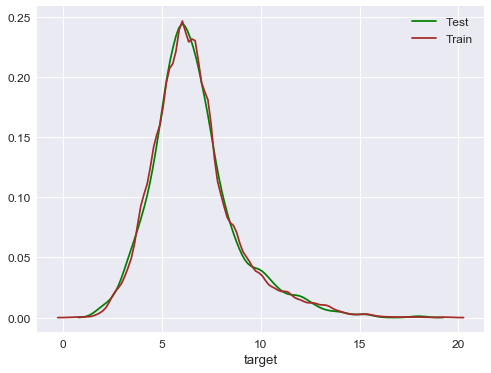

In [18]:
from sklearn.model_selection import train_test_split
import numpy as np
bins = np.arange(0, 20, 1.5)
y_binned = np.digitize(df['target'], bins)

X_train, X_test, y_train, y_test = train_test_split(df.drop(['target'], axis=1), df['target'], 
                                                    test_size=0.2, random_state=0, stratify=y_binned)

# sanity check
plt.figure(figsize=(8, 6))
ax = plt.axes()
sns.distplot(y_test, kde=True, ax=ax, bins=30, color='green', hist=False, label='Test') 
sns.distplot(y_train, kde=True, ax=ax, bins=30, color='brown', hist=False, label='Train')  

Data sets are quite well parted, but I decided to do better.

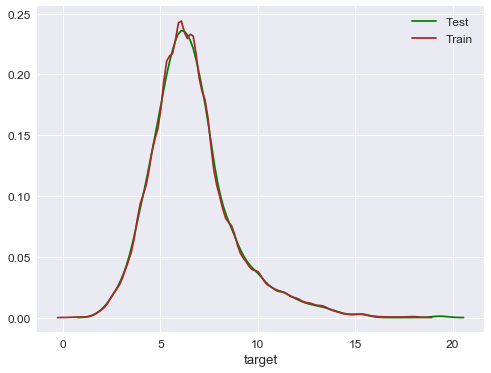

In [19]:
from sklearn.model_selection import train_test_split

# To enable explicit stratified split we need the data set to contain only classes where value counts >= 2
value_counts = df['target'].value_counts()
value_counts = value_counts[value_counts < 2]

df_to_stratify = df[~df['target'].isin(value_counts.index)]
df_not_stratify = df[df['target'].isin(value_counts.index)]

dfs_zip = zip(train_test_split(df_to_stratify.drop(['target'], axis=1), df_to_stratify['target'], 
                               test_size=0.2, random_state=0, stratify=df_to_stratify['target']),
              train_test_split(df_not_stratify.drop(['target'], axis=1), df_not_stratify['target'], 
                               test_size=0.2, random_state=0))

X_train, X_test, y_train, y_test = [pd.concat(dfs) for dfs in dfs_zip]

# sanity check
plt.figure(figsize=(8, 6))
ax = plt.axes()
sns.distplot(y_test, kde=True, ax=ax, bins=30, color='green', hist=False, label='Test') 
sns.distplot(y_train, kde=True, ax=ax, bins=30, color='brown', hist=False, label='Train') 

Some transformers

In [22]:
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin


# LabelBinarizer has problem with working directly in pipelines
class CustomBinarizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None,**fit_params):
        self.lb = LabelBinarizer().fit(X)
        return self
    def transform(self, X):
        return self.lb.transform(X)  

    
class OutlierClipper(BaseEstimator, TransformerMixin):
    '''
    Clip data based on simple univariate analysis of outliers from EDA
    (We used to analysis the whole dataset so it is data lekeage a little bit,
    but if we are not deeply concerned about completely unbias estimates of our predictors
    this should not constitute much of a problem)
    '''
    def fit(self, X, y=None,**fit_params):
        return self
    def transform(self, X):
        X = X.copy()
        X['height'] = X['height'].clip(upper=0.5)
        X['whole weight'] = X['whole weight'].clip(upper=2.55)
        X['shucked weight'] = X['shucked weight'].clip(upper=1.245)
        X['viscera weight'] = X['viscera weight'].clip(upper=0.575)
        X['schell weight'] = X['schell weight'].clip(upper=0.85)
        
        return X   


# transform categorical representation into numerical one
# ensure right order ['I', 'F', 'M'] for easier split in tree model
# OneHot encoding is not preferable for tree like models
sex_ordinal_cat = FunctionTransformer(
    lambda X: X['sex'].astype('category', categories=['I', 'F', 'M']).cat.codes.values.reshape(-1, 1),
    validate=False)

In [23]:
def plot_predictions(y_train, y_test, preds_train, preds_test):
    '''
    Plots distributions of predicted values against true values
    '''
    plt.figure(figsize=(16, 10))
    plt.suptitle('Distribution of predicted vs true value for Linear regression', size=15)
    plt.subplot(2, 2, 1)
    sns.distplot(y_test, kde=True, bins=30, color='green', hist=False, label='True values') 
    sns.distplot(preds_test, kde=True, bins=30, color='blue', hist=False, label='Predicted values') 
    plt.title('Test dataset')
    plt.xlabel('')

    plt.subplot(2, 2, 2)
    plt.scatter(y_test, preds_test)
    plt.plot(range(20), range(20), c='brown')
    plt.ylabel('Predicted values')
    plt.title('Test dataset')

    plt.subplot(2, 2, 3)
    sns.distplot(y_train, kde=True, bins=30, color='green', hist=False, label='True values') 
    sns.distplot(preds_train, kde=True, bins=30, color='blue', hist=False, label='Predicted values') 
    plt.title('Train dataset')

    plt.subplot(2, 2, 4)
    plt.scatter(y_train, preds_train)
    plt.plot(range(20), range(20), c='brown')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.title('Train dataset')



At first I decided to use a simple method - linear regression. It doesn't require lot of data to train and can be considered as good baseline model. Often the results of the model can be easily interpretable, unfortunately not in our case due to high collinearity. Nevertheless I believe that starting from a simple model is always good thing before trying more complex ones.

(To have in mind: Moderate multicollinearity may not be problematic. However, severe multicollinearity is a problem because it can increase the variance of the coefficient estimates and make the estimates very sensitive to minor changes in the model. The result is that the coefficient estimates are unstable and difficult to interpret.)

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer



pip = make_union(make_pipeline(FunctionTransformer(lambda X: X['sex'].values.reshape(-1, 1), validate=False),
                               CustomBinarizer()),
                FunctionTransformer(lambda X: X.drop('sex', axis=1), validate=False))

X_train_lr = pip.fit_transform(X_train)
X_test_lr = pip.transform(X_test)

lr = LinearRegression().fit(X_train_lr, y_train)

In [25]:
# with clipping values which might be considered as outliers
pip = make_union(make_pipeline(FunctionTransformer(lambda X: X['sex'].values.reshape(-1, 1), validate=False),
                               CustomBinarizer()),
                 make_pipeline(OutlierClipper(),
                              FunctionTransformer(lambda X: X.drop('sex', axis=1), validate=False)))
                
X_train_lr = pip.fit_transform(X_train)
X_test_lr = pip.transform(X_test)

lr = LinearRegression().fit(X_train_lr, y_train)

In [26]:
preds_test = lr.predict(X_test_lr)
preds_train = lr.predict(X_train_lr)

print("RMSE test: %.4f \nRMSE train: %.4f "
      % (RMSE(y_test, preds_test), RMSE(y_train, preds_train)))

RMSE test: 1.4616 
RMSE train: 1.4504 


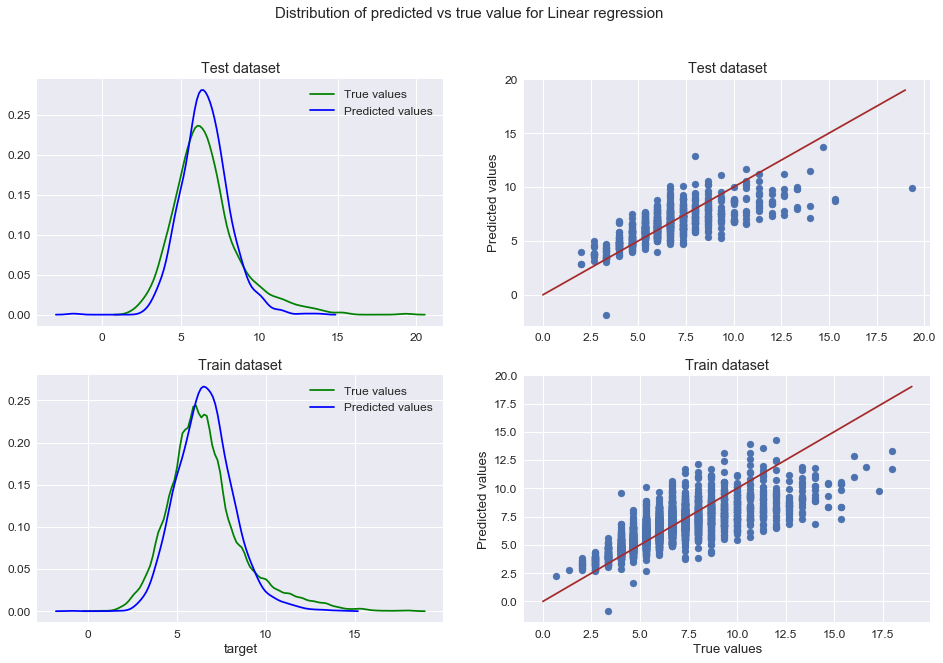

In [27]:
plot_predictions(y_train, y_test, preds_train, preds_test)

We can notice that model tend to predict values more close to the mean, whereas true shape of distrubution is smoother. It also overestimate the age where its true value <6 and tends to underestimate when its higher than 6. There are some observations whose predicted value is really far from real one. The conlusion is that model of linear regression indeed do not catch all dependences in data and may fail due to multicollinearity.

My second choice is to use the algorithm of Boosting Trees - xgboost. The general idea of the model is to compute a sequence of simple trees, where each successive tree is built for the prediction residuals of the preceding tree. We decided to approach a problem as a regression so boosting happening here is for regression tree models.
Tree-based models work well with data consisting outliers and correlated variables. Furthermore xgboost proved to give state of art performance in many applications.

In [28]:
import numpy as np
import xgboost as xgb

pip = make_union(sex_ordinal_cat,
                 FunctionTransformer(lambda X: X.drop('sex', axis=1), validate=False))

X_train_xgb = pip.fit_transform(X_train)
X_test_xgb = pip.transform(X_test)

model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train_xgb, y_train)
preds_test = model_xgb.predict(X_test_xgb)
preds_train = model_xgb.predict(X_train_xgb)

print("RMSE test: %.4f \nRMSE train: %.2f "
      % (RMSE(y_test, preds_test), RMSE(y_train, preds_train)))

RMSE test: 1.4630 
RMSE train: 1.27 


We can see that xgb model did not make better job with prediction on test dataset. The difference in RMSE between train and test data sets indicates significent overfitting problem. There might be space for improvements. Nevertheless we do not tune model yet.

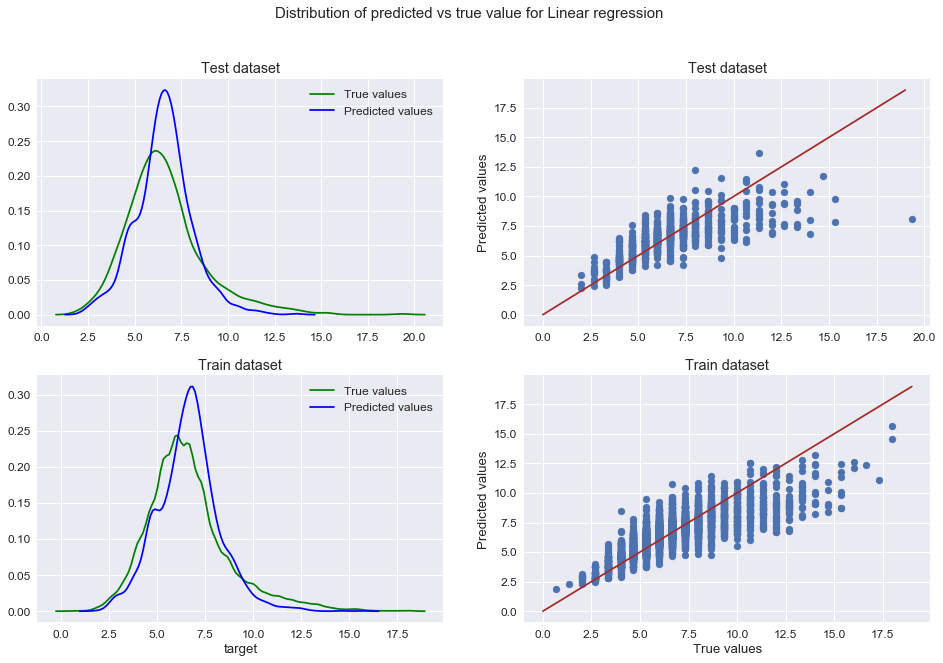

In [29]:
plot_predictions(y_train, y_test, preds_train, preds_test)

We can notice similar problem with xgboost as it overestimates age where its true value is below 6 and underestimates when it is over 6. The distribution of predicted data is very steep, especially for test dataset. That might be a problem due to the fact that  dataset consist of target value highly concetrated around a median and predictor overfit to it. Trying oversampling might be worth consideration.

***
# Other tasks - Pick 2 of them



# 3. Dimensionality reduction


##### What are the applications of the dimensionality reduction?   

###### Pick two algorithms that could be useful for exploration or supervised learning problem and apply them on the data. Describe what you've found. Provide a short description of the algorithms you've chosen.

Note: feature selection is also one type of dimensionality reduction.


# 4. Clustering

##### What is clustering used for? Name the popular types of clustering. Pick two clustering algorithms and run them on the dataset. Describe what you've found. Does it help with the supervised learning task?

Clustering base on grouping a set of objects into subsets such that all elements within a group are more similar among them than they are to the others. In other words we use it to find potential clusters, groups of data which are close to each other (similar) in a high dimensional space. From practical point of view it could help us to understand the structure of the data, for example find customer segments in our CRM database (so we can use it as a part of exploratory data analysis). Our findings can be also transfered to supervised learning tasks, used for feature engineering. Recently I used it in one of the ongoing [competition](https://www.kaggle.com/c/two-sigma-financial-news) in kaggle. The goal of the competition is to optimize trading decision for portfolio of stocks so they produce as high as possible return while minimizing the risk (defined as day-to-day variance in return). I used clustering to group stocks which move smililarly. As a result I got stocks grouped according to industry they operate. The feature proved to be usefull to minimize the risk. I another kaggle competition which aimed at predicting the total ride duration of taxi trips in New York City I used it to define subregion in a city based on longitude and latitude from GPS. Based on intuition we can say that there are part of the city which are subject to more severe traffic problems. That also enhanced the model performance.

Clustering use similarity measures for finding potential clusters. The way we find similar objects can differ. Here I shortlisted some types of clustering which represent different approaches:
* connectivity models, e.g  hierarchical clustering
* centroid models, e.g. k-means
* distribution models, e.g. expectation-maximization algorithm
* density models, e.g. HDBSCAN 

In outline we can also consider clustering algorithms to belong to one of the subgroup: soft/hard clustering methods. First of it, assigns a probability or likelihood of data points to be in particular clusters (fuzzy method), second decides either data point belongs to a cluster completely or not (exclusive method).

In [30]:
import hdbscan
from sklearn.pipeline import make_union
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler


# I have checked two versions: first using standarization of the data and second without it.
# Conlusions are similar


# pip_cluster = make_pipeline(make_union(sex_ordinal_cat, 
#                                        FunctionTransformer(lambda X: X.drop('sex', axis=1), validate=False)),
#                             MinMaxScaler())

pip_cluster = make_union(sex_ordinal_cat, 
                         FunctionTransformer(lambda X: X.drop('sex', axis=1), validate=False))


X_cluster = pip_cluster.fit_transform(df.drop('target', axis=1))
y_cluster = df['target']

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, prediction_data=True).fit(X_cluster)
clusters_pred, cluster_prob = hdbscan.approximate_predict(clusterer, X_cluster)

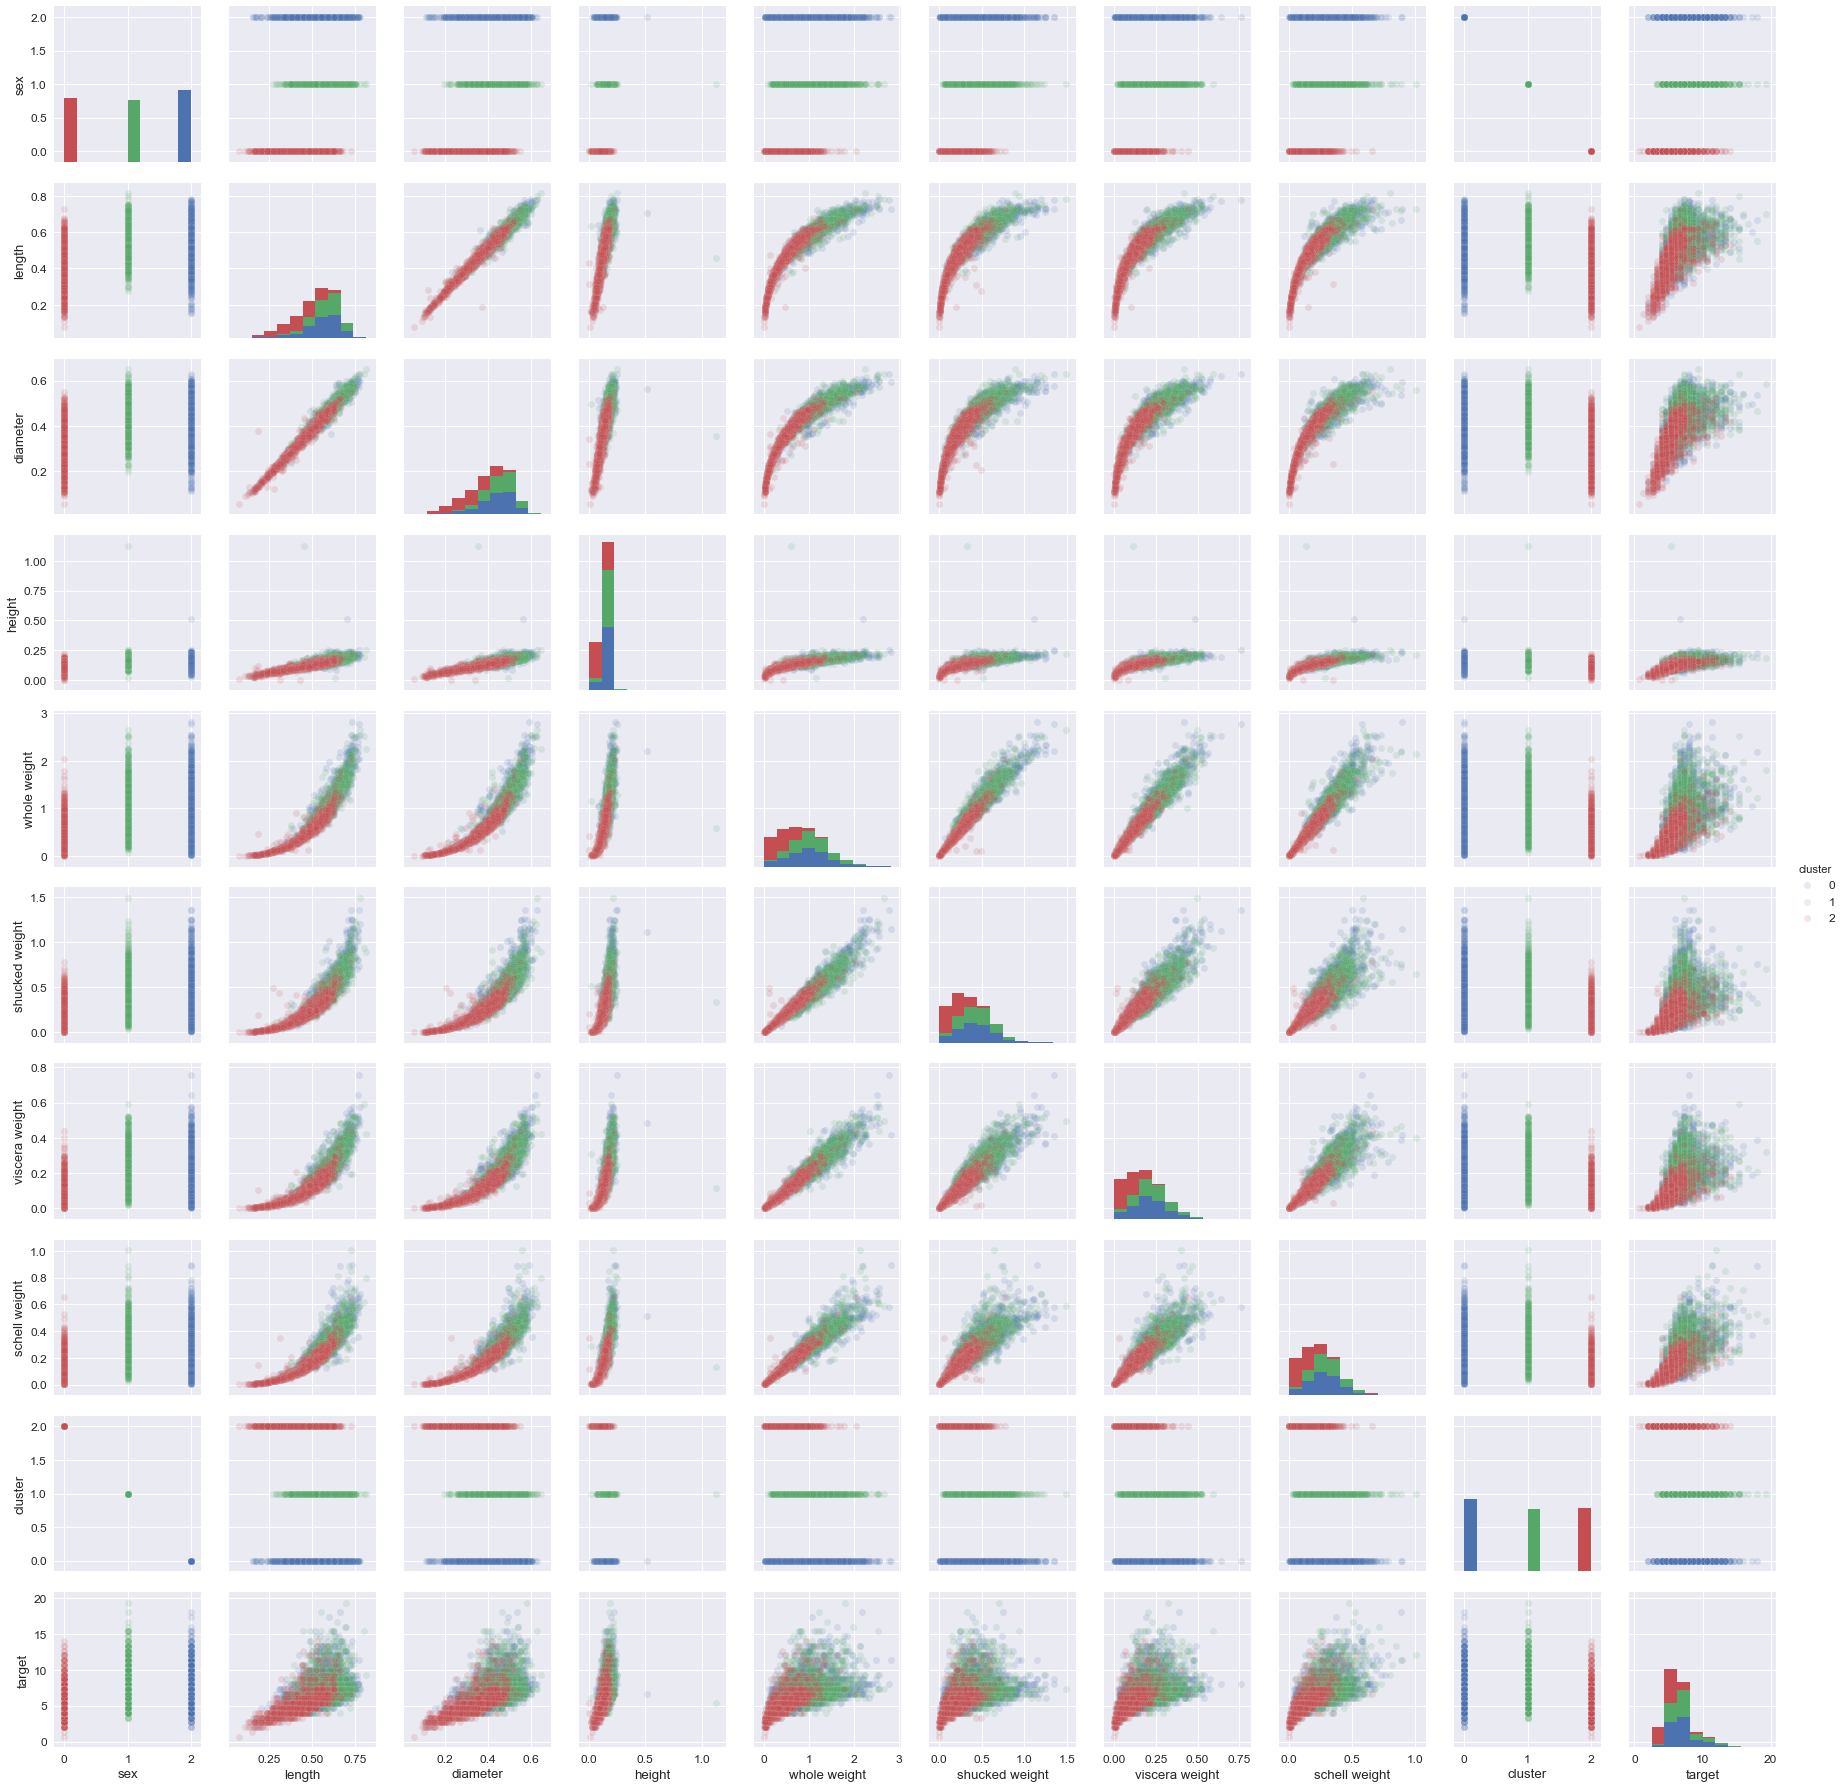

In [31]:
cluster_df = pd.DataFrame(X_cluster, columns=df.columns[:-1])
cluster_df['cluster'] = clusters_pred
cluster_df['target'] = y_cluster

sns.pairplot(cluster_df, hue='cluster', plot_kws={'alpha':0.15})

Clusters found by algorithms hold identical information as feature 'sex'. That is not very usefull. But maybe probabilities given by the algorithms can somehow help.

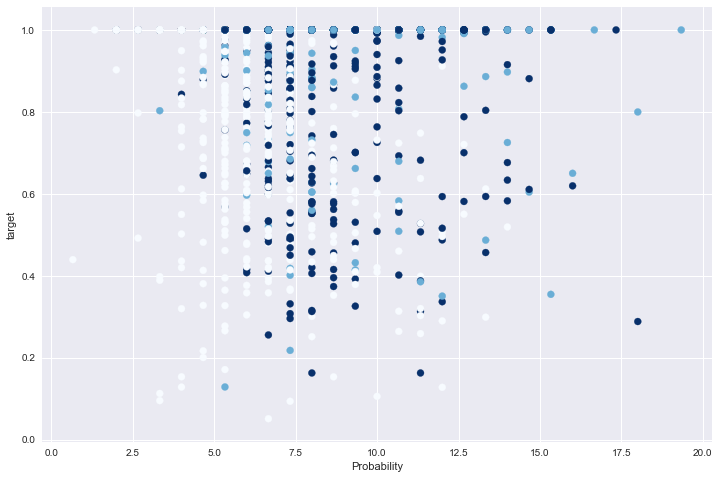

In [414]:
cluster_df['cluster_prob'] = cluster_prob

plt.figure(figsize=(12, 8))
plt.scatter(cluster_df['target'], cluster_df['cluster_prob'],
            c=cluster_df['sex'], cmap='Blues', alpha=1)
plt.xlabel('Probability')
plt.ylabel('target')

The plot is not clear, so I grouped data according to sex and plot separately. I also add some statistics about target value . For this purpose I created two groups:
* observations for which clustering algorithm was sure how to classify (prob=1)
* observations for which clustering was note sure how to classify (prob<1)

Categorical variable 'sex': 0 for Infant (I), 1 for Femal (F), 1 for Male (M).

Suspect points with prob < 1

        target          
         mean       std
sex                    
0.0  6.614525  1.977089
1.0  8.714976  2.949064
2.0  8.553846  2.368858 


Points with prob ==1

        target          
         mean       std
sex                    
0.0  4.767615  1.222308
1.0  7.347334  1.986160
2.0  6.929732  1.874120


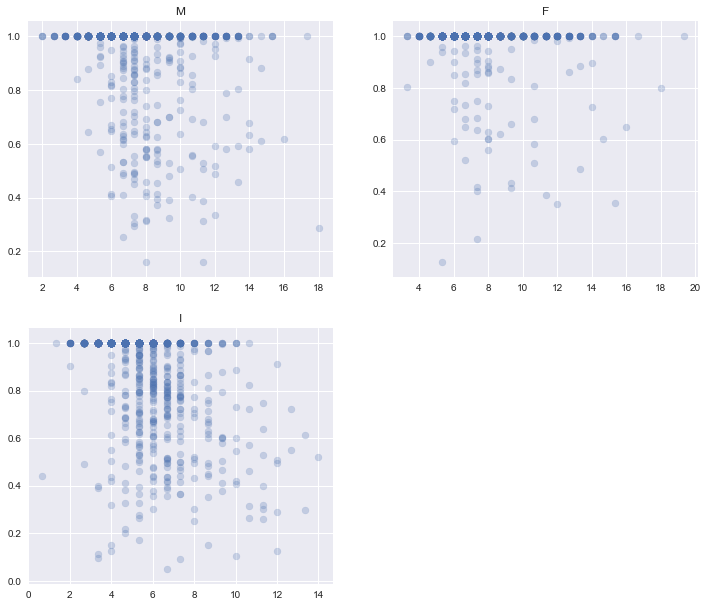

In [415]:
cluster_df['cluster_prob'] = cluster_prob
plt.figure(figsize=(12, 16))
for num, sex in enumerate(['M', 'F', 'I']):
    plt.subplot(3, 2, num+1)
    df_sex = cluster_df[df['sex']==sex]
    plt.scatter(df_sex['target'], df_sex['cluster_prob'], alpha=0.25)
    plt.title(sex)

# Devide data set into two groups, according to probability 
# that observation is of particular sex
cluster_suspect = cluster_df[cluster_df['cluster_prob']<1]
cluster_fine = cluster_df[~(cluster_df['cluster_prob']<1)]

print('Categorical variable \'sex\': 0 for Infant (I), 1 for Femal (F), 1 for Male (M).\n')
print('Suspect points with prob < 1\n\n', 
      cluster_suspect[['sex', 'target']].groupby('sex').agg([np.mean, np.std]), '\n\n')
print('Points with prob ==1\n\n',
      cluster_fine[['sex', 'target']].groupby('sex').agg([np.mean, np.std]))

One the one hand we can find that mean value for target in the group with prob<1 for sex, for all of the categories is higher but on the other hand it has higher standard deviations, that means that we can not draw clear conclusion about it. Nevertheless there is still chance that machine learning model will find it usefull, it might be right to include probability feature in dataset and test the performance.

Because clustering model kind of overfit to sex variable I will give it a try once again but this time discarding sex variable.

In [416]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, prediction_data=True).fit(X_cluster[:, 1:])
clusters_pred, cluster_prob = hdbscan.approximate_predict(clusterer, X_cluster[:, 1:])

 1    3953
-1     215
 0       9
dtype: int64

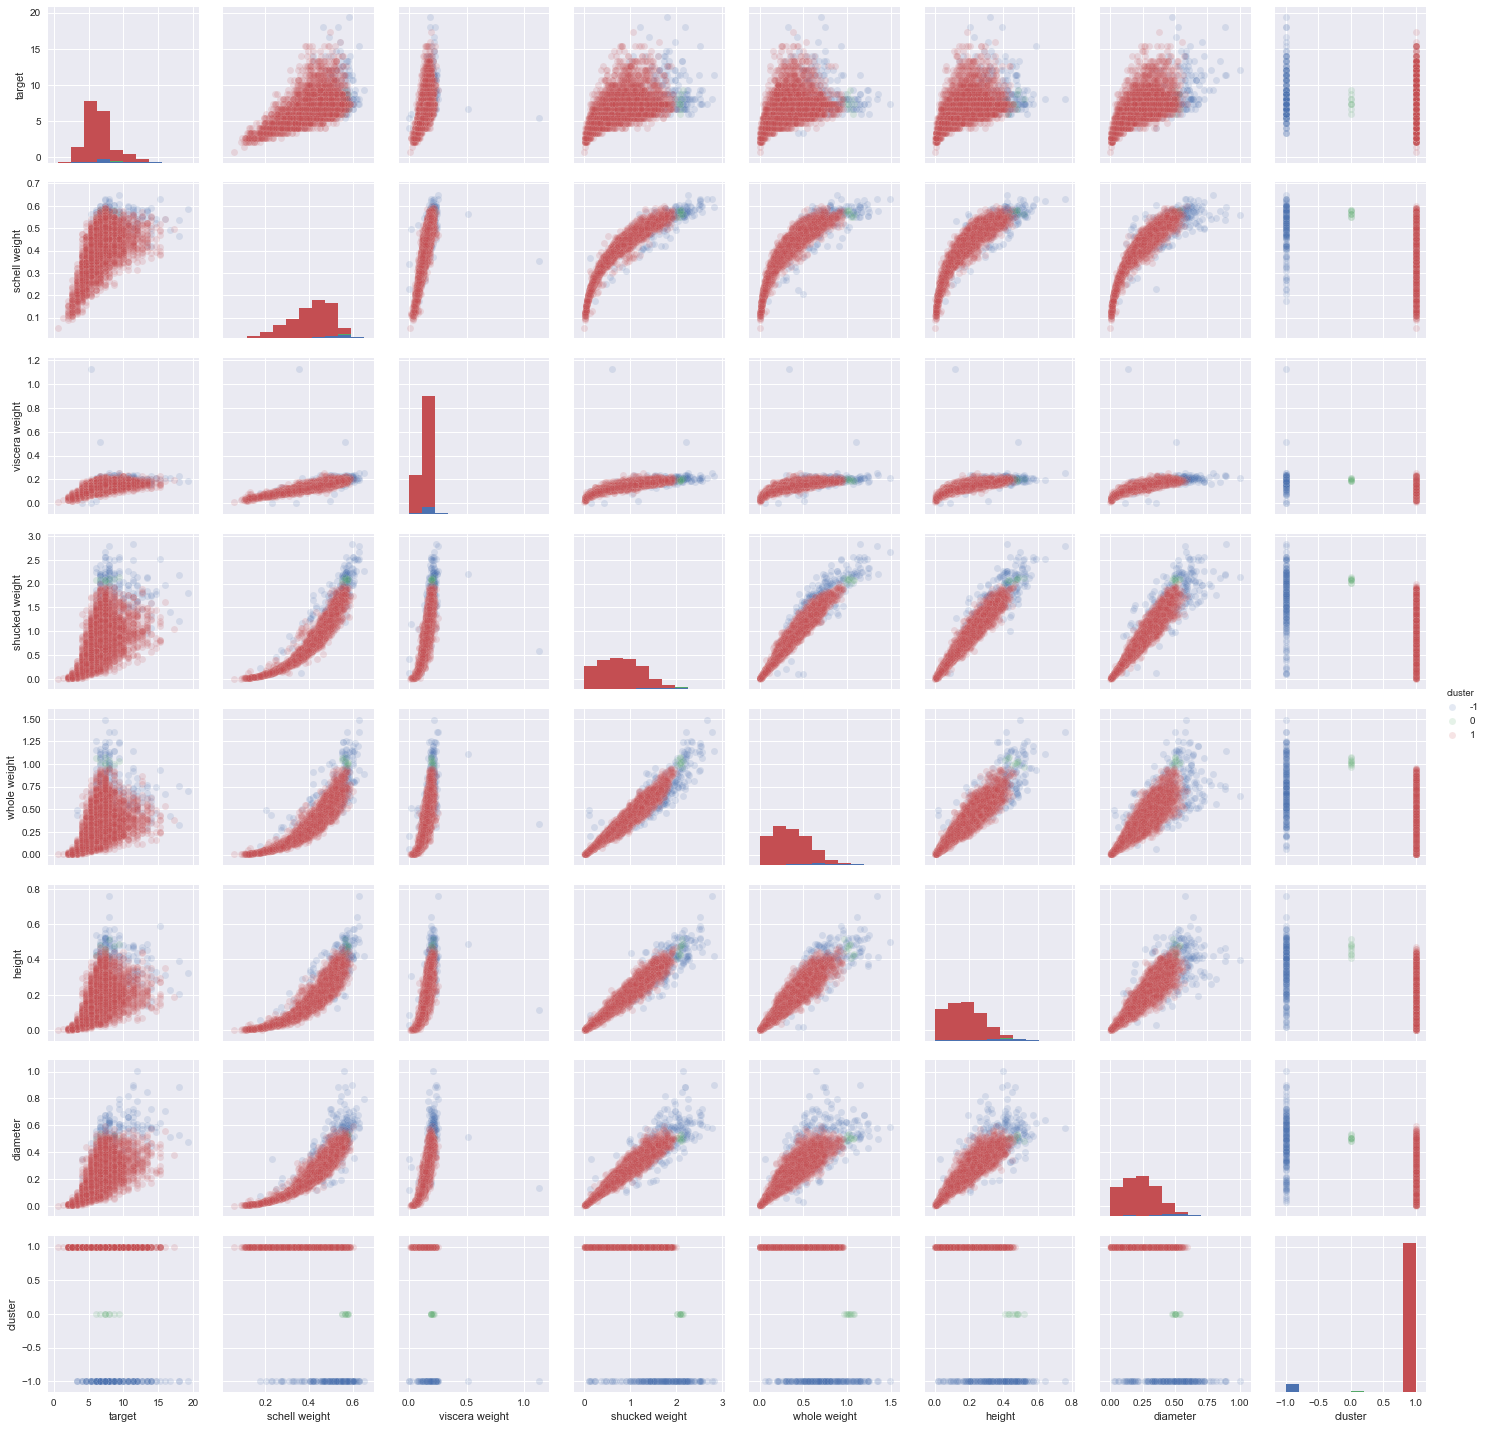

In [417]:
cluster_df = pd.DataFrame(X_cluster[:, 1:], columns=df.columns[:1:-1])
cluster_df['cluster'] = clusters_pred
cluster_df['target'] = y_cluster

sns.pairplot(cluster_df, hue='cluster', plot_kws={'alpha':0.15})
pd.Series(clusters_pred).value_counts()

It seems that algorithm found some outliers in data, that might be usefull in our supervised learning task. It is hard to say anything more at this very moment.

### K-means

Second algorithm I used is k-means. Main drawback of that algorithm is that we need to feed it with predifined number of clusters, it is also vulnerable to fall in local minima. Still it is broadly used and it is one of most popular clustering algorithms.

In [418]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_union
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler


pip_cluster = make_union(sex_ordinal_cat, 
                         FunctionTransformer(lambda X: X.drop('sex', axis=1), validate=False))

pip_cluster = make_pipeline(make_union(sex_ordinal_cat, 
                                       FunctionTransformer(lambda X: X.drop('sex', axis=1), validate=False)),
                            MinMaxScaler())

X_cluster = pip_cluster.fit_transform(df.drop('target', axis=1))
y_cluster = df['target']

inertias = []
for n in range(2, 25):
    km = KMeans(n_clusters=n)
    km.fit(X_cluster)
    inertias.append(km.inertia_)
    

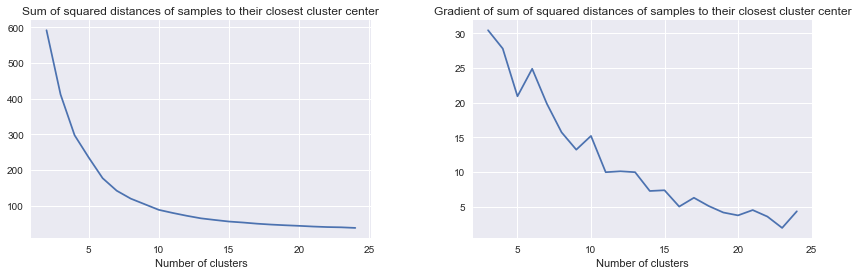

In [419]:
inertias = pd.Series(inertias)
inertias_shifed = inertias.shift()

plt.figure(figsize=(14, 4))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1, 2, 1)
plt.plot(list(range(2, 25)), inertias)
plt.title('Sum of squared distances of samples to their closest cluster center')
plt.xlabel('Number of clusters')

plt.subplot(1, 2, 2)
plt.plot(list(range(2, 25)), 100 * (inertias_shifed - inertias) / inertias_shifed)
plt.title('Gradient of sum of squared distances of samples to their closest cluster center')
plt.xlabel('Number of clusters')

6 clusters



target                
             mean       std count
cluster                          
0        7.609676  1.950581   813
1        6.198280  1.591455   659
2        7.077170  2.005747   622
3        7.776156  2.060295   685
4        6.599534  1.958287   715
5        4.309419  1.077593   683

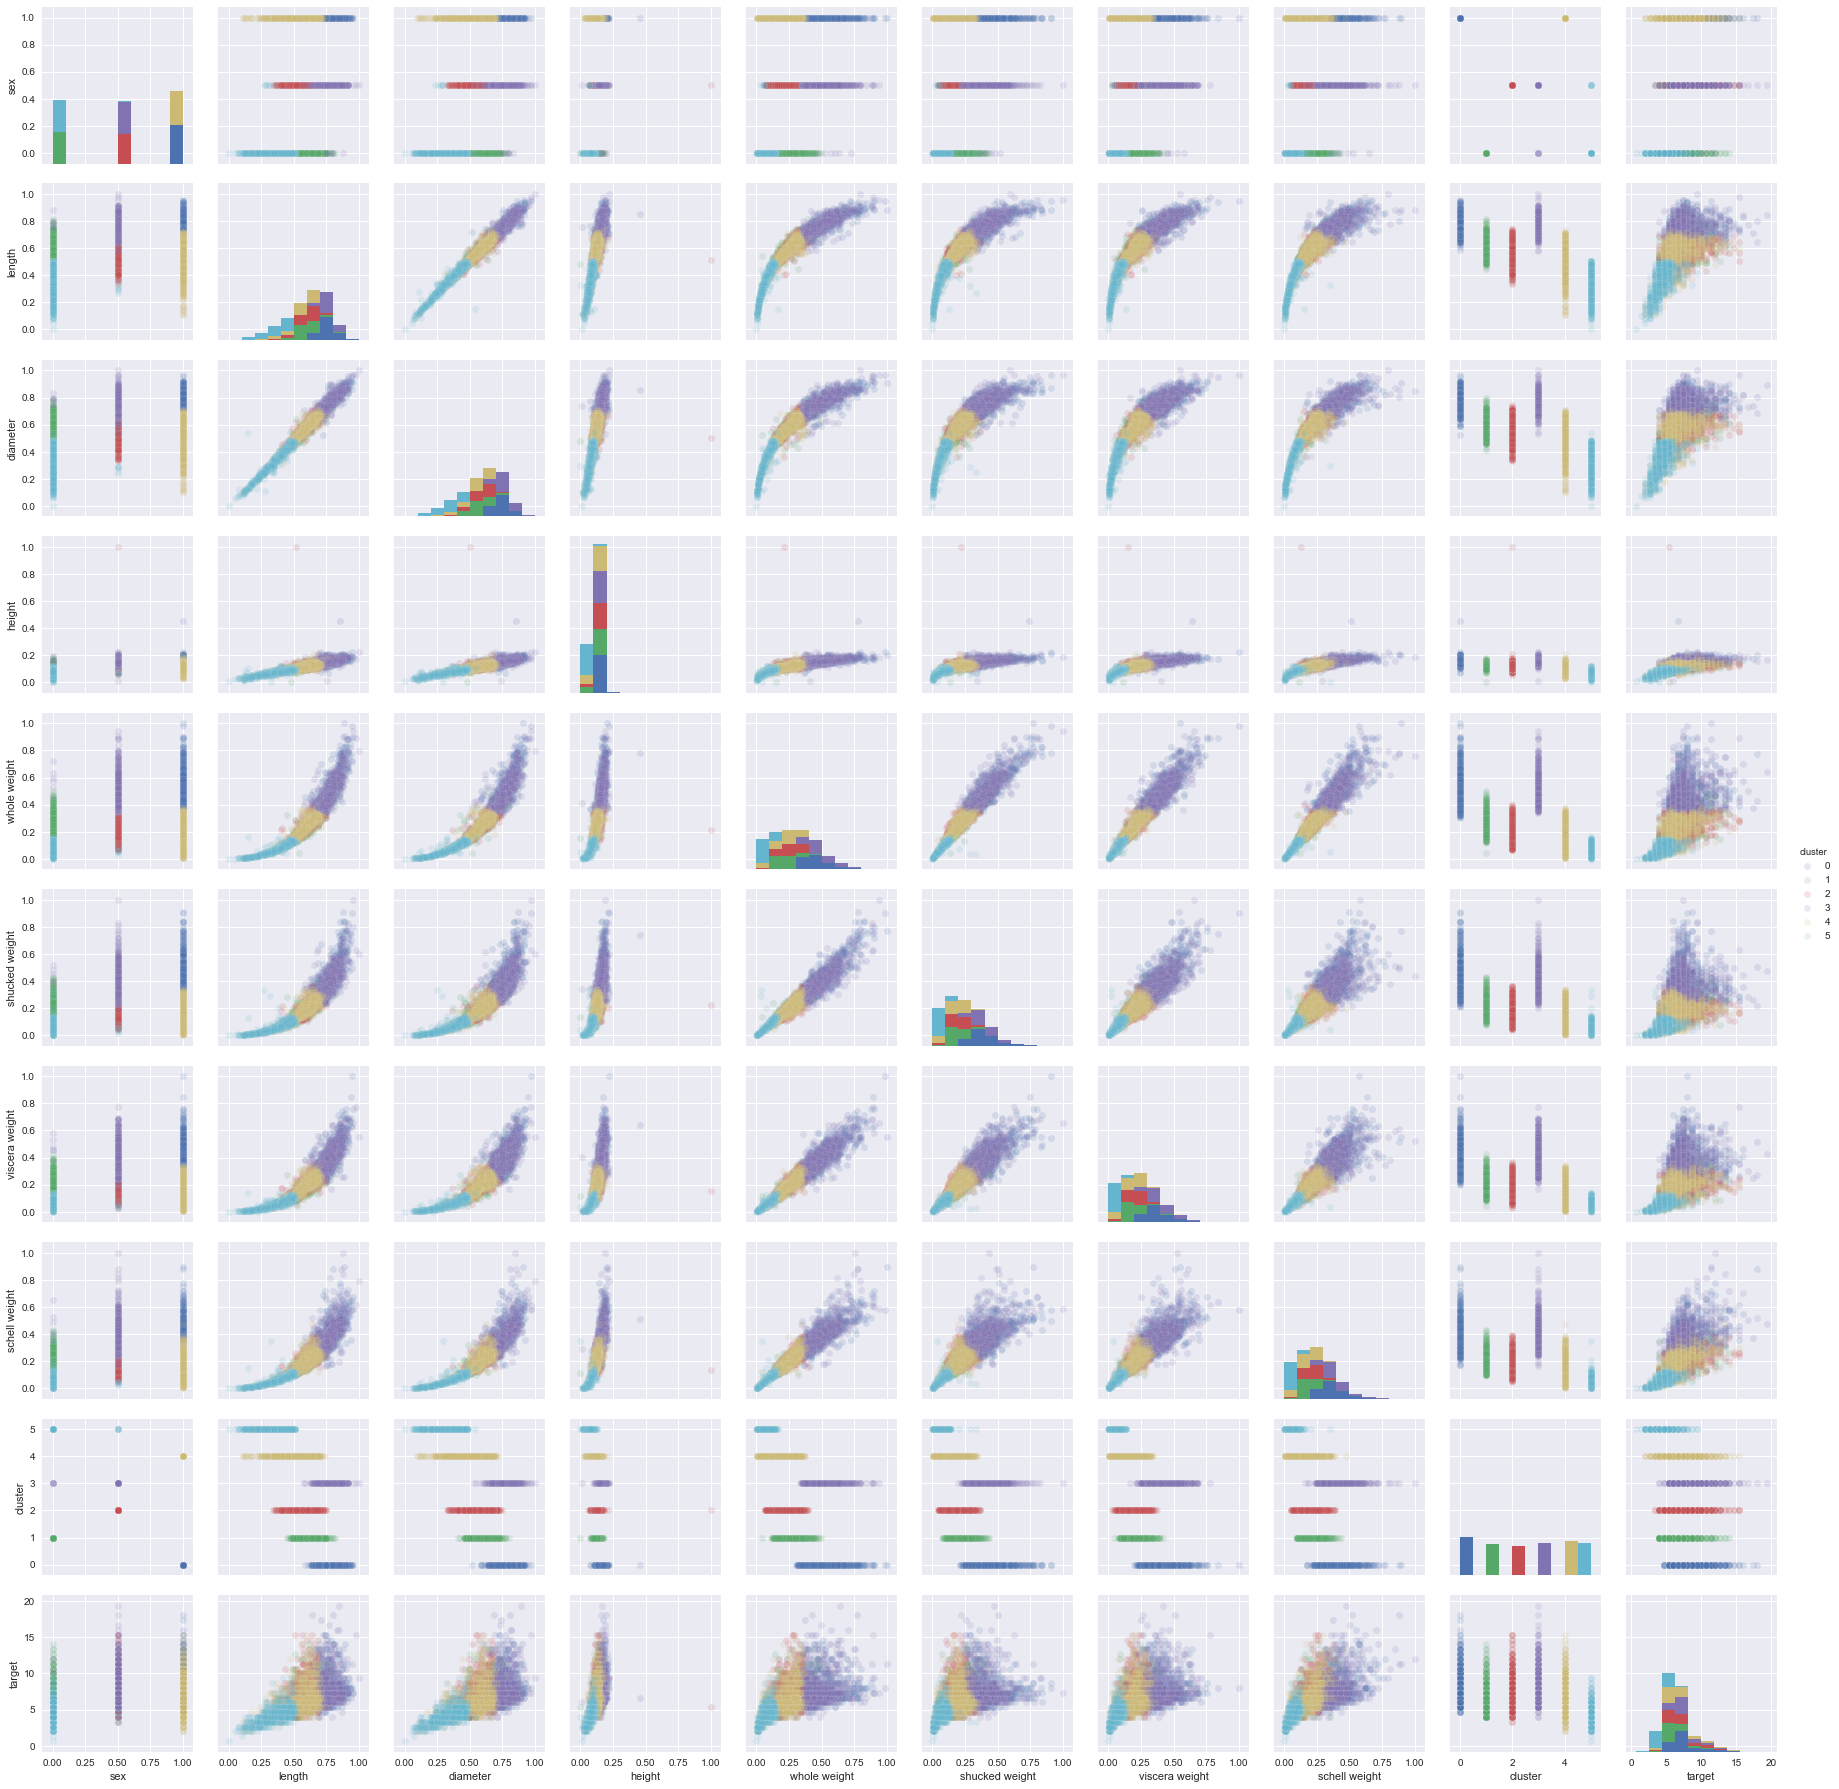

In [420]:
clusters_pred = KMeans(n_clusters=6).fit_predict(X_cluster)

cluster_df = pd.DataFrame(X_cluster, columns=df.columns[:-1])
cluster_df['cluster'] = clusters_pred
cluster_df['target'] = y_cluster

sns.pairplot(cluster_df, hue='cluster', plot_kws={'alpha':0.15})
print('6 clusters\n')
cluster_df[['cluster', 'target']].groupby('cluster').agg(['mean', 'std', 'count'])

9 clusters



target                
             mean       std count
cluster                          
0        7.350158  1.973957   634
1        6.203647  1.598156   658
2        5.569787  1.584067   203
3        7.449275  1.922342   575
4        4.319097  1.092101   679
5        6.968586  2.048878   382
6        8.083752  1.884343   199
7        8.175676  2.105126   296
8        7.046582  1.975826   551

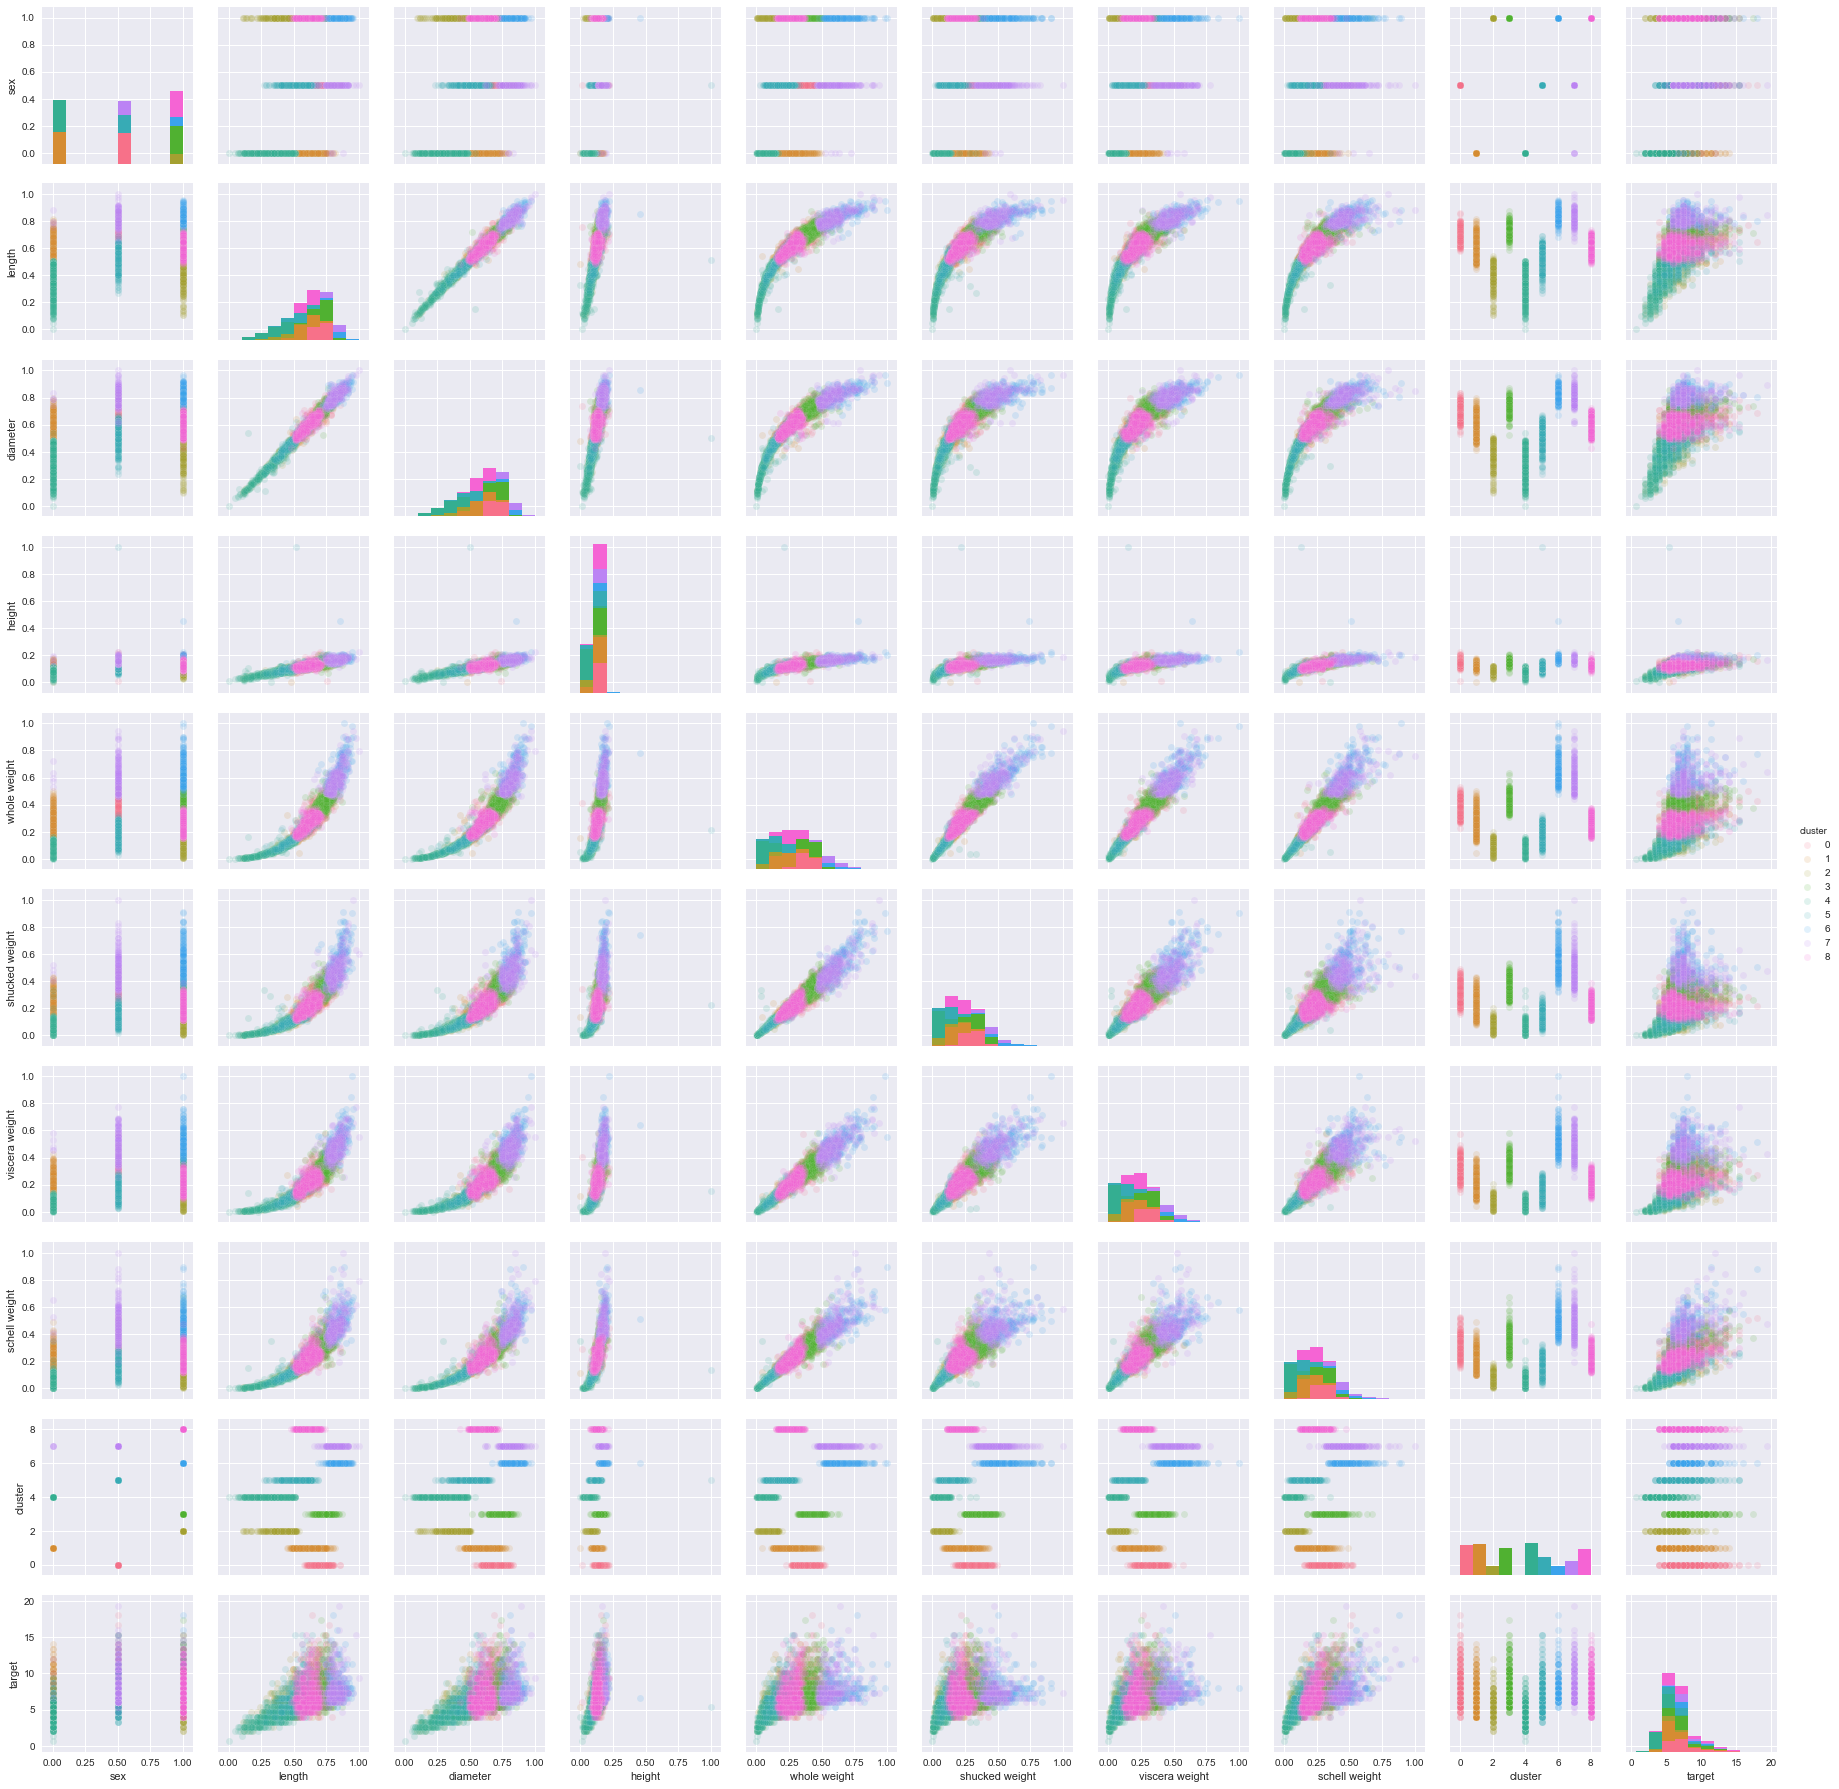

In [204]:
clusters_pred = KMeans(n_clusters=9).fit_predict(X_cluster)

cluster_df = pd.DataFrame(X_cluster, columns=df.columns[:-1])
cluster_df['cluster'] = clusters_pred
cluster_df['target'] = y_cluster

sns.pairplot(cluster_df, hue='cluster', plot_kws={'alpha':0.15})
print('9 clusters\n')
cluster_df[['cluster', 'target']].groupby('cluster').agg(['mean', 'std', 'count'])

Looking at the distribution of target variable against clusters, we might asume that they might be usefull in prediction. If our goal was to understand the clusters we would need to dig deeper.


# 5. Hyperparameter selection and crossvalidation

##### We imagine that you did some modeling in 2nd task with the methods that have some tunable hyperparameters. If they don't, either find a versions of them that have that are tunable, or pick the different ones.

##### Tune the hyperparameters of your model using cross-validation. Does it make it better? Does it solve overfitting problems? Is cross-validation score worse than score that your model achieves on test set?

**-

In [421]:
'''
Some transformers
'''

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelBinarizer
from sklearn.cluster import KMeans
import hdbscan

# wraper for HDBSCAN as it does not implement fit_transform function
# which makes it impossible to use in pipelines
class CustomHDBSCAN(BaseEstimator, TransformerMixin):
    def __init__(self, probs=False):
        self.probs = probs     
    def fit(self, X, y=None,**fit_params):
        self.clusterer = hdbscan.HDBSCAN(min_cluster_size=15, prediction_data=True).fit(X)
        return self
    def transform(self, X):
        return hdbscan.approximate_predict(self.clusterer, X)[self.probs].reshape(-1, 1)
    
# LabelBinarizer has problem with working directly in pipelines
class CustomBinarizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None,**fit_params):
        self.lb = LabelBinarizer().fit(X)
        return self
    def transform(self, X):
        return self.lb.transform(X)   

# wraper for KMeans to use in pipelines
class CustomKMeans(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters     
    def fit(self, X, y=None,**fit_params):
        self.KMeans = KMeans(n_clusters=self.n_clusters).fit(X)
        return self
    def transform(self, X):
        return self.KMeans.predict(X).reshape(-1, 1)

In [422]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import xgboost as xgb
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold
import numpy as np


class OptimizeModel():
    '''
    Class for tuning a model either xgboost or ElasticNet (LinearRegresion) using  hyperopt package.
    Validation is made using k-fold stratified cross-validation.
    Results from tunings are stored in: 
        trials (hyperopt object), 
        dictonary of losses (which includes RMSE metric for all folds, mean RMSE across folds and 
            standard deviation of all folds for every fitted model), 
        list of parametrs used while tuning (for every fitted model)
        
    Methods:
        optimize - run hyperparameter tuning
        predict - use n_best parameters found during tuning to build models and made prediction
            (final prediction is the average of predictions made by n_best models)
                                
    '''
    def __init__(self, X_train, y_train, model, space, evals, pipe, kfold=5, optimizer=tpe.suggest):
        '''
        model - either 'xgb' or 'lr'
        space - space dictionary for hyperopt fmin function
        evals - number of models to check\create during tuning
        pipe - pipeline used for transformation the data sets
        kfold - number of folds for kfold cross-validation
        '''
        self.model = model
        self.space = space
        self.evals = evals
        self.pipe = pipe
        self.kfold = kfold
        self.optimizer = optimizer
        
        self.trials = Trials()
        self.loss_dict = {'losses':[], 'mean_loss':[], 'std_loss':[]}
        self.param_list = []
        
        self.X_trains = [None] * kfold
        self.X_vals = [None] * kfold
        self.y_trains = [None] * kfold
        self.y_vals =[None] * kfold
        
        skf = StratifiedKFold(n_splits=kfold, random_state=0)
        for fold, (train_index, test_index) in enumerate(skf.split(X_train, np.digitize(y_train, np.arange(0, 20, 1.5)))):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            self.y_trains[fold], self.y_vals[fold] = y_train.iloc[train_index], y_train.iloc[test_index]
            self.X_trains[fold] = self.pipe.fit_transform(X_train_fold)
            self.X_vals[fold] = self.pipe.transform(X_val_fold)
    
    def RMSE(self, y_true, preds):
        return np.sqrt(mean_squared_error(y_true, preds))

    def _score(self, params):
        losses = []
        for fold in range(self.kfold):
            X_train_fold, X_val_fold = self.X_trains[fold], self.X_vals[fold]
            y_train_fold, y_val_fold = self.y_trains[fold], self.y_vals[fold]
    
            if self.model == 'xgb':
                xgb_model = xgb.XGBRegressor(**params, 
                                             n_estimators=400,
                                             n_jobs=3,
                                             random_state=0)

                xgb_model.fit(X_train_fold, y_train_fold.values.reshape(-1, 1), 
                              eval_set=[(X_val_fold, y_val_fold.values.reshape(-1, 1))], 
                              early_stopping_rounds=40,
                             verbose=False)

                preds_val = xgb_model.predict(X_val_fold, ntree_limit=xgb_model.best_iteration)
            elif self.model == 'lr':
                lr = ElasticNet(**params)
                lr.fit(X_train_fold, y_train_fold.values.reshape(-1, 1))
                preds_val = lr.predict(X_val_fold)

            losses.append(self.RMSE(y_val_fold, preds_val))

        self.loss_dict['losses'].append(losses)
        self.loss_dict['mean_loss'].append(np.mean(losses))
        self.loss_dict['std_loss'].append(np.std(losses))
        self.param_list.append(params)

        loss = np.mean(losses)
        return {'loss': loss, 'status': STATUS_OK}


    def optimize(self):
        fmin(self._score, self.space, algo=self.optimizer, max_evals=self.evals, trials = self.trials)
        return self #{'loss_dict': self.loss_dict, 'param_list': self.param_list, 'trials': self.trials}

    def predict(self, X_test, n_best=1): 
        '''
        Uses n_best parameters found during tuning to build models and made prediction
            (final prediction is the average of predictions made by n_best models).
        Every model is trained kfold times during kfold cross-validation, prediction on test data set
        is made on every fold and then averaged.
        '''
        X_test = self.pipe.transform(X_test)
        preds_test = 0
        model_nums = pd.DataFrame(self.loss_dict).sort_values('mean_loss').head(n_best).index.tolist()
        
        for model_num in model_nums:
            params = self.param_list[model_num]
            for fold in range(self.kfold):
                X_train_fold, X_val_fold = self.X_trains[fold], self.X_vals[fold]
                y_train_fold, y_val_fold = self.y_trains[fold], self.y_vals[fold]

                if self.model == 'xgb':
                    xgb_model = xgb.XGBRegressor(**params, 
                                                 n_estimators=400,
                                                 n_jobs=3,
                                                 random_state=0)

                    xgb_model.fit(X_train_fold, y_train_fold.values.reshape(-1, 1), 
                                  eval_set=[(X_val_fold, y_val_fold.values.reshape(-1, 1))], 
                                  early_stopping_rounds=40,
                                 verbose=False)

                    preds_kfold_test = xgb_model.predict(X_test, ntree_limit=xgb_model.best_iteration)
                elif self.model == 'lr':
                    lr = ElasticNet(**params)
                    lr.fit(X_train_fold, y_train_fold.values.reshape(-1, 1))
                    preds_kfold_test = lr.predict(X_test)

                preds_test += preds_kfold_test * (1/(n_best*self.kfold))
        return preds_test

In [423]:
space_xgb = {'learning_rate': hp.quniform('learning_rate', 0.01, 0.25, 0.02),
        'max_depth':  hp.choice('max_depth', np.arange(1, 8, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.1),
        'gamma': hp.quniform('gamma', 0, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.2, 1, 0.1),
        'reg_alpha ' :  hp.quniform('reg_alpha', 0, 10, 1),
        'reg_lambda': hp.quniform('reg_lambda', 1, 2, 0.05)
    }

pipe_xgb = make_pipeline(make_union(sex_ordinal_cat, 
                               FunctionTransformer(lambda X: X.drop('sex', axis=1), validate=False)))

space_lr = {'alpha': hp.quniform('alpha', 0, 1, 0.05),
         'l1_ratio': hp.quniform('l1_ratio', 0, 1, 0.05)
}

pipe_lr = make_pipeline(
    make_union(make_pipeline(FunctionTransformer(lambda X: X['sex'].values.reshape(-1, 1), validate=False),
                               CustomBinarizer()),
                FunctionTransformer(lambda X: X.drop('sex', axis=1), validate=False)),
    make_union(CustomHDBSCAN(True),
               FunctionTransformer(lambda X: X, validate=False)))

print("Tuning last approximately 1.5 mins.")
evals = 50
OP_lr = OptimizeModel(X_train, y_train, 'lr', space_lr, evals, pipe_lr, kfold=5, optimizer=tpe.suggest).optimize()   
OP_xgb = OptimizeModel(X_train, y_train, 'xgb', space_xgb, evals, pipe_xgb, kfold=5, optimizer=tpe.suggest).optimize()

Tuning last approximately 1.5 mins.


C:\Program Files\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Program Files\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:79: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
C:\Program Files\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Program Files\Anaconda\lib\site-packag

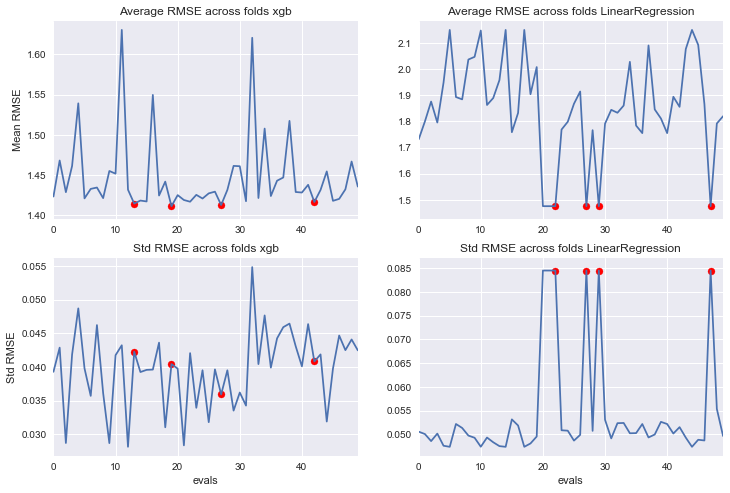

In [424]:
xgb_results_df = pd.DataFrame(OP_xgb.loss_dict)
lr_results_df = pd.DataFrame(OP_lr.loss_dict)
xgb_best_models = xgb_results_df.sort_values('mean_loss').head(4).index.tolist()
lr_best_models = lr_results_df.sort_values('mean_loss').head(4).index.tolist()

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
xgb_results_df['mean_loss'].plot()
plt.scatter(xgb_best_models, xgb_results_df.loc[xgb_best_models, 'mean_loss'], c='r')
plt.title('Average RMSE across folds xgb')
plt.ylabel('Mean RMSE')

plt.subplot(2, 2, 2)
lr_results_df['mean_loss'].plot()
plt.scatter(lr_best_models, lr_results_df.loc[lr_best_models, 'mean_loss'], c='r')
plt.title('Average RMSE across folds LinearRegression')

plt.subplot(2, 2, 3)
xgb_results_df['std_loss'].plot()
plt.scatter(xgb_best_models, xgb_results_df.loc[xgb_best_models, 'std_loss'], c='r')
plt.title('Std RMSE across folds xgb')
plt.ylabel('Std RMSE')
plt.xlabel('evals')

plt.subplot(2, 2, 4)
lr_results_df['std_loss'].plot()
plt.scatter(lr_best_models, lr_results_df.loc[lr_best_models, 'std_loss'], c='r')
plt.title('Std RMSE across folds LinearRegression')
plt.xlabel('evals')

On the above charts we can see the RMSE mean and std metric from tuning process. With red dots are marked 4 best models found during tuning. We can notice significent unstability across differend folds in validation, what is not a good sign.

In [391]:
preds_xgb = OP_xgb.predict(X_test, n_best=5)
preds_lr = OP_lr.predict(X_test, n_best=5)
loss_xgb = OP_xgb.RMSE(y_test, preds_xgb)
loss_lr = OP_lr.RMSE(y_test, preds_lr)
print('Average RMSE xgboost test: %.4f\nAverage RMSE LinearRegression test: %.4f'
      % (loss_xgb, loss_lr))

preds_xgb = OP_xgb.predict(X_train, n_best=5)
preds_lr = OP_lr.predict(X_train, n_best=5)
loss_xgb = OP_xgb.RMSE(y_train, preds_xgb)
loss_lr = OP_lr.RMSE(y_train, preds_lr)
print('Average RMSE xgboost train: %.4f\nAverage RMSE LinearRegression train: %.4f'
      % (loss_xgb, loss_lr))

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:132: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
C:\Program Files\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Program Files\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Average RMSE xgboost test: 1.4422
Average RMSE LinearRegression test: 1.4595


C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:132: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
C:\Program Files\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Program Files\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Average RMSE xgboost train: 1.2454
Average RMSE LinearRegression train: 1.4510


We did not reduce overfitting problem for xgboost, even though the score has improved. Data set constist of lot of overlapping data what is hard to learn by machine learning models. Maybe tuning model by hand by imposing stronger regularization would help a little bit with overfitting problem. Models (xgboost) are trained using early stoping and tuned for validation sets so in most cases naturally they produce better score on validation set over the test set. So is here.

**-